# Time Series Module 3: ARIMA Models and Forecasting

This notebook contains code for AR, MA, ARMA, ARIMA, and SARIMA models using Python's `statsmodels` library.

### Package Installation

Run the cell bello to install the required packages

In [98]:
!pip install statsmodels pandas matplotlib numpy seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Autoregressive (AR)

This section demonstrates how to fit an Autoregressive (AR) model using the `statsmodels` library.

In [99]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

np.random.seed(72)

## 0. Data Generation

This section generates synthetic AR(2) data for demonstration purposes.

AR model: $X_t = 0.5X_{t-1} + 0.3X_{t-2} + \epsilon_t$

This section can be ignored because we will use real-world data in practice.

#

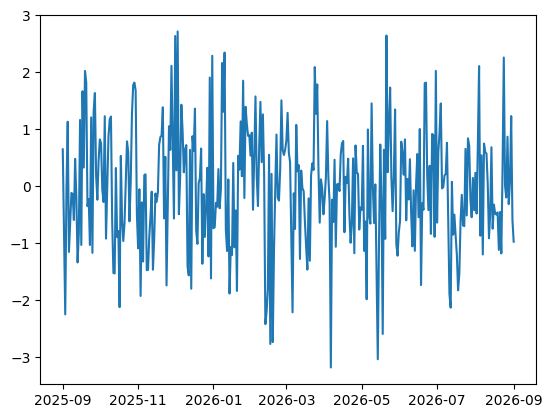

In [100]:
# Generate synthetic AR(2) data
errors = np.random.normal(0, 1, 400) # Generating noise

date_index = pd.date_range(start='9/1/2025', end='9/1/2026') # Creating date range for one year

series = [] # Empty list to hold the generated series

# MA
for index, date in enumerate(date_index):
    series.append(0.2*errors[index-1] + 0.3*errors[index-2] + errors[index]) # AR(2) process: X_t = 0.5*X_(t-1) + 0.3*X_(t-2) + e_t

# # AR
# for index, date in enumerate(date_index):
#     if index == 0:
#         series.append(errors[index]) # First value is just the error term
#     elif index == 1:
#         series.append(0.5*series[index-1] + errors[index]) # Second value depends on the first
#     else:
#         series.append(0.5*series[index-1] + 0.3*series[index-2] + errors[index]) # AR(2) process: X_t = 0.5*X_(t-1) + 0.3*X_(t-2) + e_t

# ## ARMA
# for index, date in enumerate(date_index):
#     if index == 0:
#         series.append(errors[index]) # First value is just the error term
#     elif index == 1:
#         series.append(0.5*series[index-1] + errors[index] + 0.4*errors[index-1]) # Second value depends on the first
#     else:
#         series.append(0.3*series[index-1] + 0.2*series[index-2] + errors[index] + 0.3*errors[index-1] + 0.2*errors[index-2]) # ARMA(2,2) process

data_raw = pd.Series(series, index=date_index) # Convert to pandas Series

sns.lineplot(data=data_raw) # Plot the time series data

test_data = data_raw[-5:] # Last 5 points for testing
data = data_raw[:-5] # All but last 5 points for modeling

### 1. Model Identification
Analyze ACF/PACF plots to identify model components and determine AR, MA, and seasonal orders. 

> Notice that Lags 1 and 2 are significant suggesting an AR(2) model.

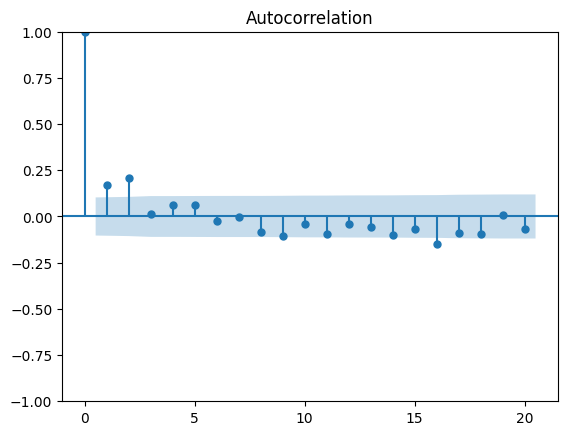

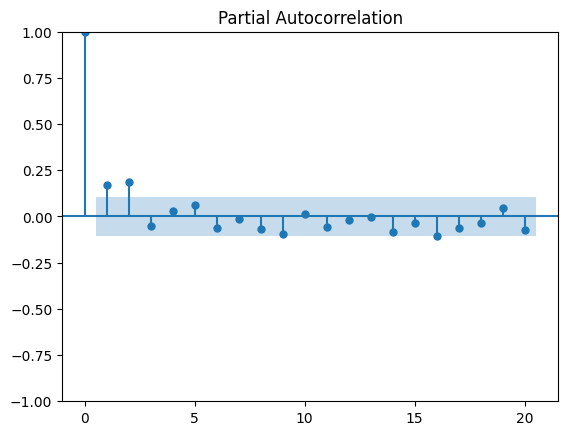

In [101]:
import matplotlib.pyplot as plt

# Analyze ACF and PACF for model identification
plot_acf(data, lags=20) # Plot ACF for 20 lags
plot_pacf(data, lags=20) # Plot PACF for 20 lags
plt.show() # Show plots

### 2. Parameter Estimation
Use maximum likelihood estimation to fit model parameters to historical data

<Axes: >

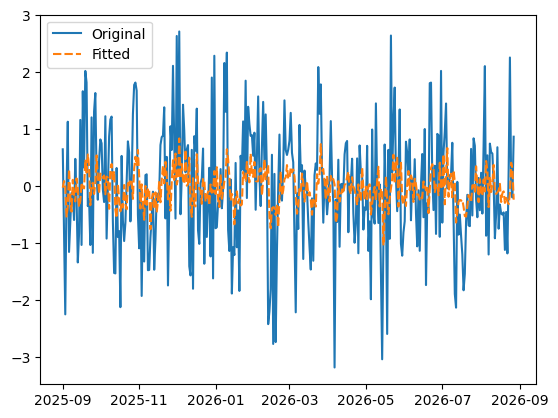

In [ ]:
model = ARIMA(data, order=(2, 0, 2)) # ARIMA(p=2, d=0, q=0) for AR(2) model
model_fit = model.fit() # Fit the model
fitted_values = model_fit.fittedvalues # Get fitted values (in-sample predictions)
df_est = pd.DataFrame({'Original': data, 'Fitted': fitted_values}) # Create DataFrame to compare original and fitted values
sns.lineplot(data=df_est) # Plot original vs fitted values

In [121]:
# summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  361
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -511.660
Date:                Fri, 24 Oct 2025   AIC                           1039.321
Time:                        23:37:51   BIC                           1070.432
Sample:                    09-01-2025   HQIC                          1051.690
                         - 08-27-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0273      0.080     -0.340      0.734      -0.185       0.130
ar.L1         -0.5481      0.284     -1.928      0.054      -1.105       0.009
ar.L2         -0.0404      0.227     -0.178      0.8

### 3. Model Validation
Check residuals for white noise and evaluate forecast accuracy, residuals should look like white noise(random)

<Axes: >

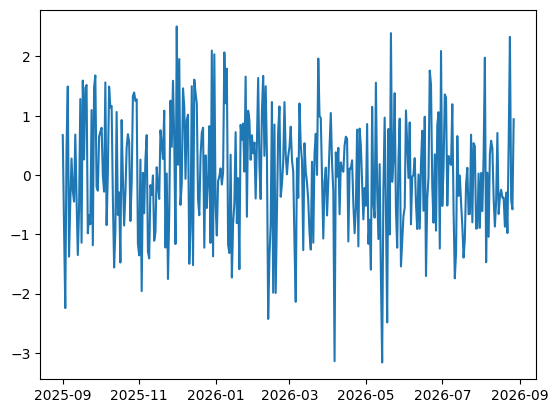

In [104]:
residuals = model_fit.resid
sns.lineplot(data=residuals)

In [105]:
# Evaluate residuals
residuals = model_fit.resid
print("Residuals Evaluation:")
print(f"Mean Absolute Error of residuals: {abs(residuals).mean():.4f}")

Residuals Evaluation:
Mean Absolute Error of residuals: 0.7944


Test Data Forecast Evaluation:
Actual test data: [-0.31441401  0.0941127   1.22951784 -0.59293976 -0.97390152]
Forecasted values: [ 0.40655424  0.35203163 -0.02796714  0.31699359  0.08644705]
Mean Absolute Error: 0.8413


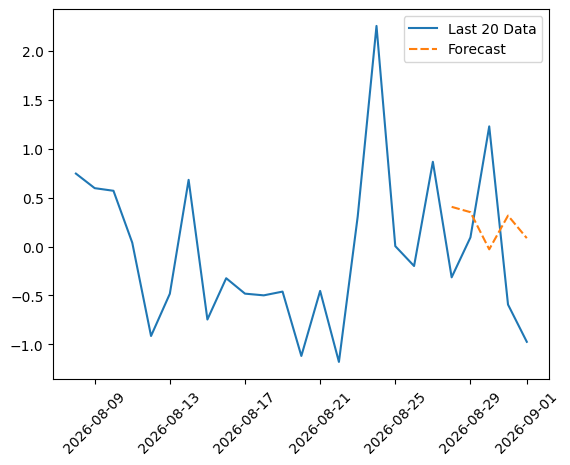

In [106]:
# Evaluate forecast accuracy on test data
test_forecast = model_fit.forecast(steps=5)
forecast_errors = test_data.values - test_forecast.values
print("Test Data Forecast Evaluation:")
print(f"Actual test data: {test_data.values}")
print(f"Forecasted values: {test_forecast.values}")
print(f"Mean Absolute Error: {abs(forecast_errors).mean():.4f}")

display_data = pd.concat([data.iloc[-20:], test_data]) # Last 20 points of training data + test data

# Graphical evaluation of residuals
df_pred = pd.DataFrame({'Last 20 Data': display_data, 'Forecast': test_forecast}) # Combine last 20 data points and forecast for comparison
sns.lineplot(data=df_pred)
plt.xticks(rotation=45) # rotate x-axis labels for better readability
plt.show()

### 4. Forecasting

Generate point forecasts and calculate prediction intervals, because this is a AR(2) model, it will only be good for 2 steps ahead.

In [107]:
# update the model with new data points
updated_data = pd.concat([data, test_data])  # Combine original data with test data, 
# you can also use data_raw here, but this is for demonstration purposes

# Update the model with all available data (including test data)
updated_model = ARIMA(updated_data, order=(2, 0, 0))
updated_model_fit = updated_model.fit()

# Forecast 2 new data points
new_forecast = updated_model_fit.forecast(steps=2)

print("Updated Model Forecast for 2 New Data Points:")
for i, (index, value) in enumerate(new_forecast.items()):
    print(f"Forecast for point {202 + i}: {value:.4f}")

Updated Model Forecast for 2 New Data Points:
Forecast for point 202: -0.2633
Forecast for point 203: -0.2349
